# 0.0 IMPORTS

In [84]:
from datetime import datetime
import warnings
import pickle
import seaborn                          as sns
import pandas                           as pd
import numpy                            as np
import matplotlib.pyplot                as plt

## 0.1 Helper Functions

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:,.4f}".format

## 0.2 Loading Data

In [70]:
# Path
path_data = "../data/raw/"

# Files
file_train = "train.csv"

# CSV
df_train = pd.read_csv(path_data + file_train, low_memory=False)

# 1.0 DATA DESCRIPTIONS

In [71]:
df1_train =               df_train.copy()

## 1.1 Data Dimensions

In [72]:
print( 'Dataset: {}\n - Number of Rows: {} and Number of Columns: {}\n'.format('train', df1_train.shape[0], df1_train.shape[1]) )

Dataset: train
 - Number of Rows: 2018352 and Number of Columns: 9



## 1.2 Data Types and Memory Usage

In [73]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


## 1.3 Change Data Types

In [74]:
df1_train["datetime"] = pd.to_datetime(df1_train["datetime"])

df1_train["county"]         = df1_train["county"].astype("uint8")
df1_train["is_business"]    = df1_train["is_business"].astype("uint8")
df1_train["is_consumption"] = df1_train["is_consumption"].astype("uint8")
df1_train["product_type"]   = (
    df1_train["product_type"]
    .replace(
        {0: "combined", 1: "fixed", 2: "general_service", 3: "spot"}
    )
    .astype("category")
)

df1_train = df1_train.set_index("row_id").reset_index(drop=True)
df1_train = df1_train.drop(columns=["prediction_unit_id", "data_block_id"])

## 1.4 Data Types and Memory Usage After Change Data Types

In [75]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   county          uint8         
 1   is_business     uint8         
 2   product_type    category      
 3   target          float64       
 4   is_consumption  uint8         
 5   datetime        datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(1), uint8(3)
memory usage: 38.5 MB


In [76]:
df1_train.head()

,county,is_business,product_type,target,is_consumption,datetime
0,0,0,fixed,0.7130,0,2021-09-01
1,0,0,fixed,96.5900,1,2021-09-01
2,0,0,general_service,0.0000,0,2021-09-01
3,0,0,general_service,17.3140,1,2021-09-01
4,0,0,spot,2.9040,0,2021-09-01


## 1.4 Check NA

In [77]:
df1_train.isna().sum()

county              0
is_business         0
product_type        0
target            528
is_consumption      0
datetime            0
dtype: int64

A princípio, por se tratar de pouco mais de 500 nulos em comparação com mais de 2 milhões do total da base, esses registros serão removidos.

In [78]:
df1_train.dropna(inplace=True)

## 1.5 Descriptive Statistical

In [79]:
num_attributes = df1_train.select_dtypes(include=['uint8', 'float64'])
cat_attributes = df1_train.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.5.1 Numerical Attributes

A princípio, por se tratar de pouco mais de 500 nulos em comparação com mais de 2 milhões do total da base, esses registros serão removidos.

In [80]:
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns={'index': 'attributes'})

,attributes,mean,median,std,min,max,skew,kurtosis
0,county,7.2970,7.0000,4.7810,0.0000,15.0000,0.0234,-1.2282
1,is_business,0.5368,1.0000,0.4986,0.0000,1.0000,-0.1477,-1.9782
2,target,274.8556,31.1330,909.5024,0.0000,"15,480.2740",7.6761,73.3034
3,is_consumption,0.5000,0.5000,0.5000,0.0000,1.0000,0.0000,-2.0000


### 1.5.2 Categorical Attributes

In [81]:
print('Valor minimo:', format(df1_train['datetime'].min()))
print('Valor maximo:', format(df1_train['datetime'].max()))

Valor minimo: 2021-09-01 00:00:00
Valor maximo: 2023-05-31 23:00:00


# 2.0 FEATURE ENGINEERING

In [82]:
df2_train = df1_train.copy()

## 2.4 - Feature Engineering

Criação de campos a partir do 'datetime'

In [90]:
df2_train["month"]   = df2_train["datetime"].dt.month
df2_train["day"]     = df2_train["datetime"].dt.day
df2_train["weekday"] = df2_train["datetime"].dt.weekday
df2_train["hour"]    = df2_train["datetime"].dt.hour
df2_train["year"]    = df2_train["datetime"].dt.year
df2_train['week_of_year'] = df2_train['datetime'].dt.isocalendar().week

In [118]:
df2_train = (
    df2_train
    .assign(day_period=
        np.where(
            df2_train['hour'] <= 6, "dawn",
            np.where(
                df2_train['hour'] <= 12, "morning",
                np.where(
                    df2_train['hour'] <= 18, "afternoon", "night"
                )
            )
        )
    )
)

## 2.5 Change Types of Feature Engineering

In [122]:
df2_train["month"]        = df2_train["month"].astype("uint8")
df2_train["day"]          = df2_train["day"].astype("uint8")
df2_train["weekday"]      = df2_train["weekday"].astype("uint8")
df2_train["hour"]         = df2_train["hour"].astype("uint8")
df2_train["year"]         = df2_train["year"].astype("uint16")
df2_train["week_of_year"] = df2_train["week_of_year"].astype("uint8")

In [123]:
df2_train["day_period"]   = (
    df2_train["day_period"]
    .replace(
        {0: "drawn", 1: "morning", 2: "afternoon", 3: "night"}
    )
    .astype("category")
)

# 4.0 EXPLORATORY DATA ANALYSIS

In [128]:
df3_train = df2_train.copy()

## 4.1 - Univariate Analysis

### 4.1.1 - Response Variable

In [139]:
(
    df3_train
    .assign(QUARTIL=lambda x: pd.qcut(x['datetime'], 5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"]))
    .pivot_table(index=["product_type", "is_business"], columns="QUARTIL", values="target", aggfunc="mean")
)

QUARTIL                           Q1       Q2       Q3       Q4       Q5
product_type    is_business                                             
combined        1           233.0133 204.4291 213.1588 269.9479 267.0214
fixed           0            25.6102  48.9554  58.8582  61.4302  92.3990
                1           116.6987 107.4346 108.8707 151.7305 148.2402
general_service 0            10.5506  11.9947   8.0285   8.3525   7.3700
                1            21.9181  27.4513  24.8321  37.8158  45.0749
spot            0           123.7960 166.5035 192.2222 184.3832 300.0961
                1           648.1576 742.5317 671.8021 766.2210 843.0907

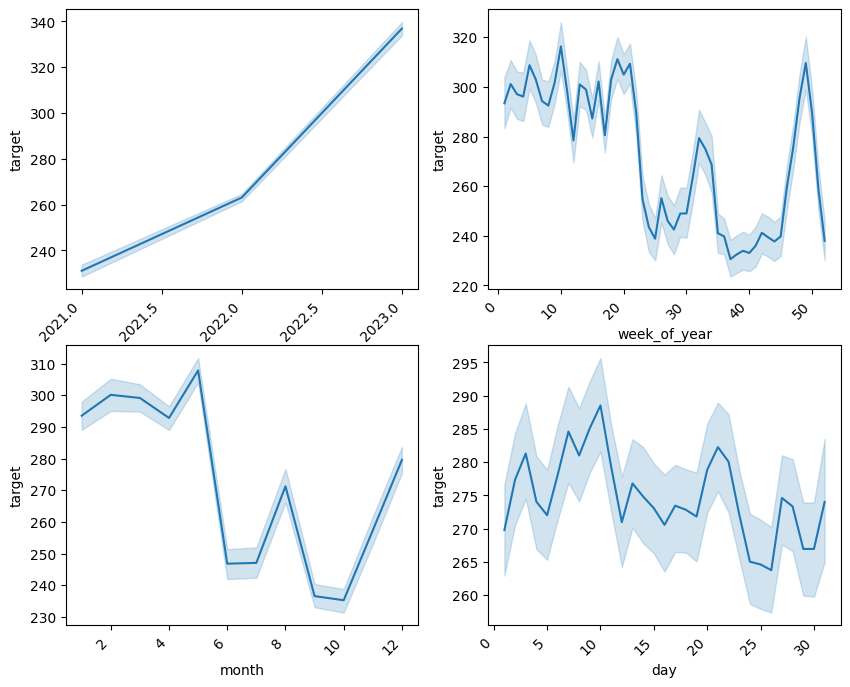

In [129]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))

sns.lineplot(x='year', y='target', data=df3_train, ax=ax[0, 0])
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=45, ha='right');

sns.lineplot(x='week_of_year', y='target', data=df3_train, ax=ax[0, 1])
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=45, ha='right');

sns.lineplot(x='month', y='target', data=df3_train, ax=ax[1, 0])
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=45, ha='right');

sns.lineplot(x='day', y='target', data=df3_train, ax=ax[1, 1])
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=45, ha='right');

### 4.1.2 - Numerical Variable

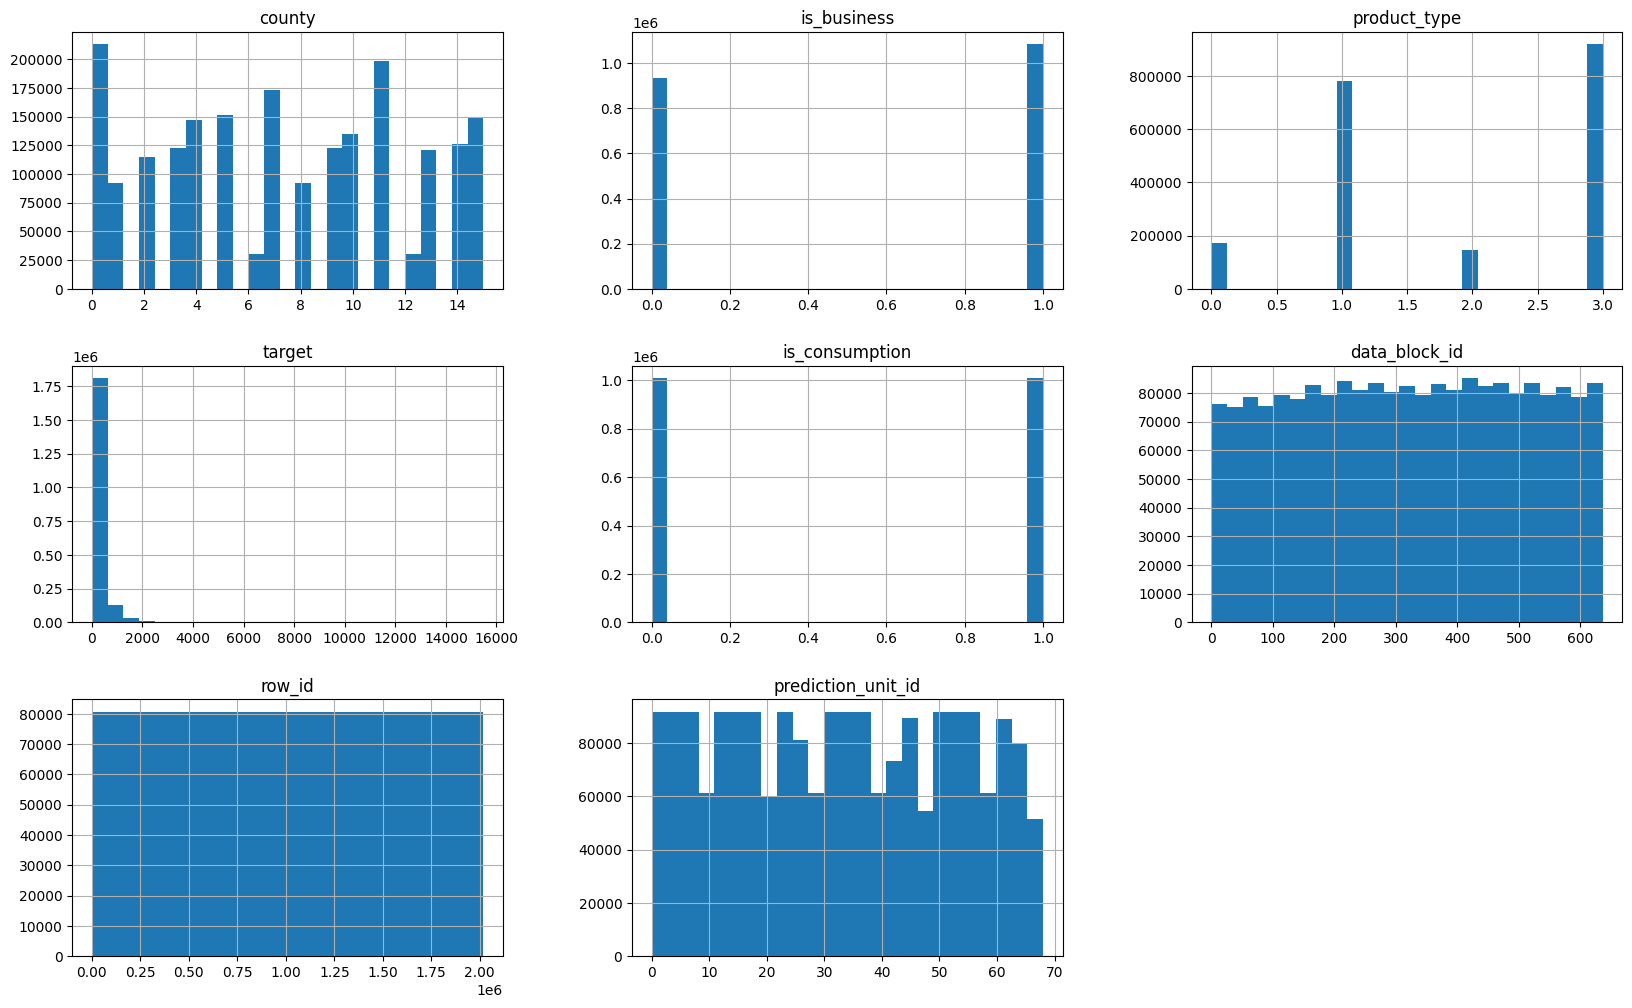

In [23]:
num_attributes.hist(figsize=(20,12), bins=25);

## 4.2 - Bivariate Analysis

### H1 - Quais são os produtos mais contratados por condado?
****

In [24]:
hip_1 = df4.assign(desc_product_type = lambda x: x['product_type'].map({0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}))
hip_1['county'] = hip_1['county'].astype(str)
hip_1 = hip_1.assign(desc_county = lambda x: x['county'].map(county_names))
hip_1 = hip_1[['desc_product_type', 'target', 'desc_county']].groupby(['desc_county', 'desc_product_type']).median().reset_index()

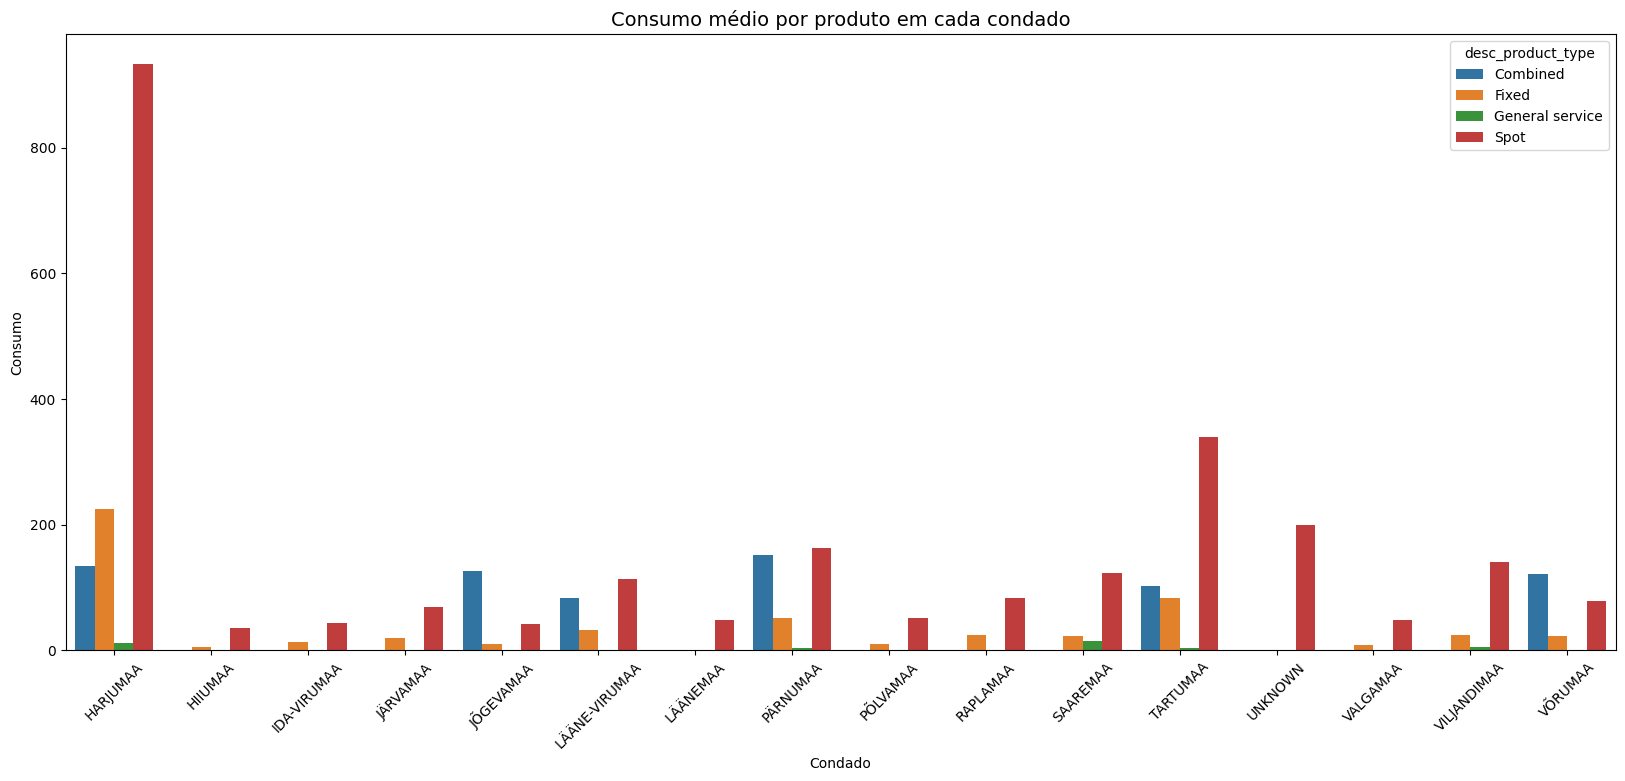

In [25]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='desc_county', y='target', data=hip_1, hue='desc_product_type', ax=ax)

ax.set_title('Consumo médio por produto em cada condado', fontsize=14)
ax.set_xlabel('Condado', fontsize=10)
ax.set_ylabel('Consumo', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

## 4.3 - Multivariate Analysis

### 4.3.1 - Numerical Attributes

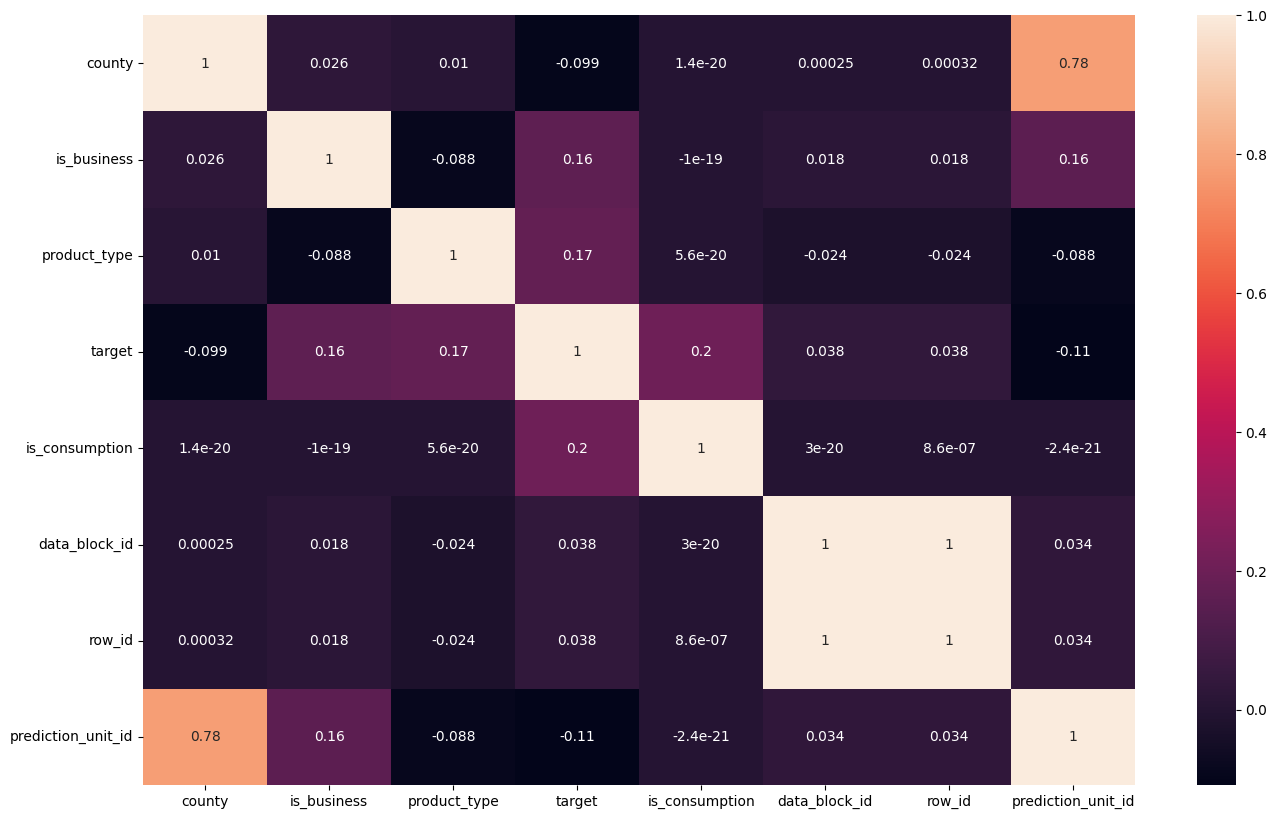

In [30]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(16,10))
sns.heatmap(correlation, annot=True);

### 4.3.2 - Caterogical Attributes

In [61]:
cat_attributes = df4.select_dtypes( include='object' )

In [63]:
cat_attributes.value_counts(normalize=True)

day_period
afternoon    0.2501
morning      0.2501
night        0.2501
dawn         0.2498
Name: proportion, dtype: float64

# 5.0 DATA PREPARATION

In [64]:
df5 = df4.copy()

## 5.1 - Normalizacao

## 5.2 - Rescaling

In [ ]:
plt.figure(figsize=(16,10))
sns.boxplot(y=df5['<var>']);

In [ ]:
dir_parameter = 'src/parameter/'

# Example RobustScaler
rs = RobustScaler()
df5['<var>'] = rs.fit_transform( df5[['<var>']].values )
pickle.dump( rs, open(dir_parameter + '<archive>.pkl', 'wb') )

# Example MinMaxScaler
mms = MinMaxScaler()
df5['<var>'] = mms.fit_transform( df5[['<var>']].values )
pickle.dump( mms, open(dir_parameter + '<archive>.pkl', 'wb') )

## 5.3 - Transformacao

### 5.3.1 - Encoding

In [ ]:
dir_parameter = 'src/parameter/'

# Example One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['<var>'], columns=['<var>'] )

# Example Label Encoding
le = LabelEncoder()
df5['<var>'] = le.fit_transform( df5['<var>'] )
pickle.dump( le, open(dir_parameter + '<archive>.pkl', 'wb') )

# Example Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extented': 3}
df5['<var>'] = df5['<var>'].map( assortment_dict )

### 5.3.2 - Response Variable Transformation

In [ ]:
# Example
df5['<var>'] = np.log1p( df5['<var>'] )

plt.figure(figsize=(16,10))
sns.distplot(df5['<var>'])

### 5.3.3 - Nature Transformation

In [ ]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 FEATURE SELECTION

In [ ]:
df6 = df5.copy()

cols_drop = []
df6.drop(cols_drop, axis=1, inplace=True)

## 6.1 - Split Dataframe into training and test dataset

In [ ]:
X = df6.drop('<var>', axis=1)
Y = df6['<var>']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2 ,random_state=42)

# 7.0 MACHINE LEARNING MODELLING

## 7.1 Example Model

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

### 7.1.1 Example Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr )
lr_result_cv

# 8.0 HYPERPARAMETER FINE TUNING

# 9.0 TRANSLATE AND INTERPRETATION ERROR

## 9.1 Business Performance

## 9.2 Total Performance

## 9.3 Macinhe Learning Performance